In [1]:
pip install scikit-surprise

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split, cross_validate
from surprise import accuracy

In [3]:
# Set random seed for reproducibility
np.random.seed(42)

**Load Preprocessed Data**

Define Surprise reader and split data into train and test sets


In [5]:
# Load datasets from local directory
movies_df = pd.read_csv("./CleanedData/movies_cleaned.csv") 
ratings_df = pd.read_csv("./CleanedData/ratings_cleaned.csv")

print(ratings_df.head())

# Define a Surprise Reader (specify rating scale)
reader = Reader(rating_scale=(1, 5))

# Load data into Surprise's format
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

# Split data into train and test sets (80% train, 20% test)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

   userId  movieId  rating
0     671     6565     3.5
1     671     6385     2.5
2     671     6365     4.0
3     671     6269     4.0
4     671     6268     2.5


Train the SVD model, Compute RMSE, MSE, Precision, and Recall

In [7]:
# Initialize and train SVD model
svd = SVD(n_factors=50, biased=True, random_state=42, verbose=True)
svd.fit(trainset)

# Test model performance
predictions = svd.test(testset)

# Compute RMSE and MSE
rmse_score = accuracy.rmse(predictions)
mse_score = accuracy.mse(predictions)

print(f"RMSE of SVD Model: {rmse_score:.4f}")
print(f"MSE of SVD Model: {mse_score:.4f}")

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
RMSE: 0.8944
MSE: 0.8000
RMSE of SVD Model: 0.8944
MSE of SVD Model: 0.8000


In [8]:
# Precision & Recall Evaluation
def precision_recall_at_k(predictions, k=10, threshold=4.0):
    """
    Compute precision and recall at top-K recommendations.
    """
    user_est_true = {}
    for pred in predictions:
        user_est_true.setdefault(pred.uid, []).append((pred.est, pred.r_ui))

    precisions, recalls = [], []
    
    for user, ratings in user_est_true.items():
        # Sort user ratings by estimated rating (descending)
        ratings.sort(key=lambda x: x[0], reverse=True)
        
        # Select top-K recommendations
        top_k = ratings[:k]
        
        # Compute precision and recall
        relevant = sum((actual >= threshold) for (_, actual) in top_k)
        total_relevant = sum((actual >= threshold) for (_, actual) in ratings)
        
        precision = relevant / k
        recall = relevant / total_relevant if total_relevant > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
    
    return np.mean(precisions), np.mean(recalls)

# Evaluate Precision & Recall at K=10
precision, recall = precision_recall_at_k(predictions, k=10)
print(f"Precision@10: {precision:.4f}")
print(f"Recall@10: {recall:.4f}")

Precision@10: 0.5714
Recall@10: 0.6612


Movie Recommendation Function

In [10]:
def recommend_movies_svd(user_id, num_recommendations=10):
    """
    Generate top-N movie recommendations for a user using trained SVD model.
    """
    # Get all unique movie IDs
    all_movie_ids = movies_df['movieId'].unique()
    
    # Get movies already rated by the user
    rated_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].tolist()
    
    # Predict ratings for unrated movies
    predicted_ratings = []
    
    for movie_id in all_movie_ids:
        if movie_id not in rated_movies:
            pred = svd.predict(user_id, movie_id)
            predicted_ratings.append((movie_id, pred.est))
    
    # Sort by predicted rating (descending order)
    predicted_ratings.sort(key=lambda x: x[1], reverse=True)
    
    # Get top-N recommended movie IDs
    top_movie_ids = [movie[0] for movie in predicted_ratings[:num_recommendations]]
    
    # Return movie details
    return movies_df[movies_df['movieId'].isin(top_movie_ids)][['title', 'genres', 'release_year']]

# Example usage
user_id = 1  # Replace with any user ID
print(recommend_movies_svd(user_id, num_recommendations=5))

                                                   title  \
241                                                 Nell   
466                                 Sleepless In Seattle   
2113                                        Galaxy Quest   
2672                            The Million Dollar Hotel   
13749  Shriek If You Know What I Did Last Friday The ...   

                                 genres  release_year  
241                  ['drama,thriller']          1994  
466            ['comedy,drama,romance']          1993  
2113   ['comedy,family,sciencefiction']          1999  
2672                 ['drama,thriller']          2000  
13749                        ['comedy']          2000  


**Evaluation**

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8955  0.8943  0.9021  0.8973  0.8989  0.8976  0.0028  
Fit time          0.59    0.61    0.67    0.61    0.57    0.61    0.03    
Test time         0.06    0.07    0.10    0.06    0.06    0.07    0.02    


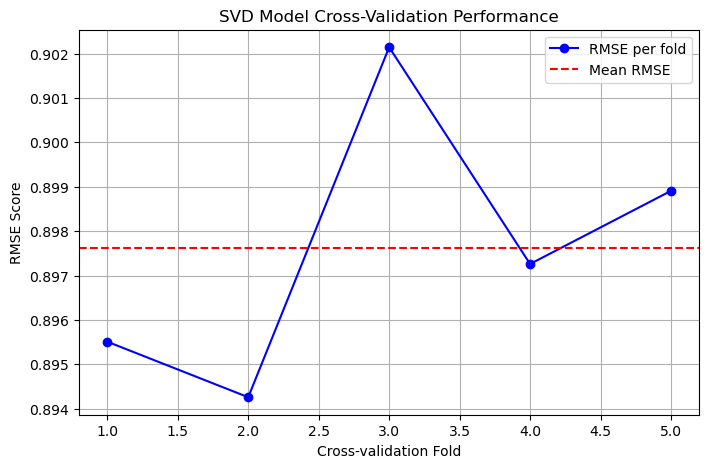

Mean RMSE across folds: 0.8976


In [12]:
# Perform cross-validation 
cross_val_results = cross_validate(SVD(random_state=42), data, measures=['RMSE'], cv=5, verbose=True)

# Extract RMSE values from each fold
rmse_scores = cross_val_results['test_rmse']

# Plot RMSE results
plt.figure(figsize=(8, 5))
plt.plot(range(1, 6), rmse_scores, marker='o', linestyle='-', color='b', label="RMSE per fold")
plt.axhline(y=np.mean(rmse_scores), color='r', linestyle='--', label="Mean RMSE")
plt.xlabel("Cross-validation Fold")
plt.ylabel("RMSE Score")
plt.title("SVD Model Cross-Validation Performance")
plt.legend()
plt.grid(True)
plt.show()

print(f"Mean RMSE across folds: {np.mean(rmse_scores):.4f}")


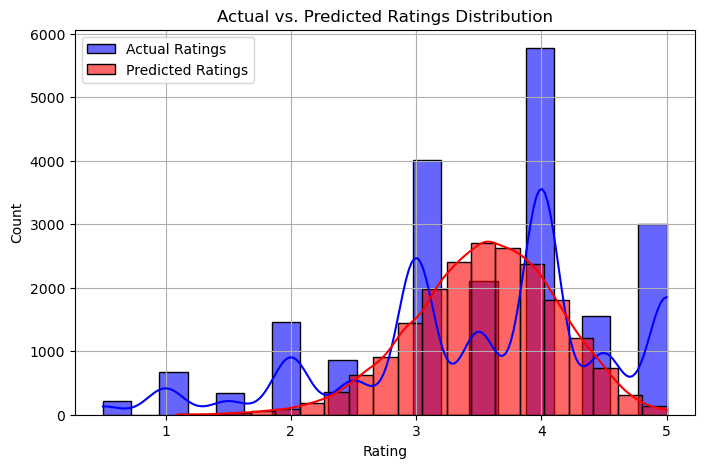

In [13]:
# Extract actual vs predicted ratings
actual_ratings = [pred.r_ui for pred in predictions]
predicted_ratings = [pred.est for pred in predictions]

# Plot actual vs predicted ratings
plt.figure(figsize=(8, 5))
sns.histplot(actual_ratings, bins=20, kde=True, color='blue', label="Actual Ratings", alpha=0.6)
sns.histplot(predicted_ratings, bins=20, kde=True, color='red', label="Predicted Ratings", alpha=0.6)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Actual vs. Predicted Ratings Distribution")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Define save path
local_dir = "./Pickle"
os.makedirs(local_dir, exist_ok=True)
    
# Save the trained SVD model
with open(f"{local_dir}/svd_model.pkl", 'wb') as f:
    pickle.dump(svd, f)

print("Saved SVD model successfully!")


Saved SVD model successfully!
